In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Minimum Variance Portfolio Optimization

Now that we have selected the 25 stocks we would like to invest in, it is time to determine how much to allocate into each stock. This part constructs a minimum-variance portfolio that aims to achieve the lowest possible volatility while following the constraints listed in the assignment. Rather than chasing maximum returns, this strategy prioritizes preserving our wealth and reducing risk. 
 
# Why Minimum Variance?
The main idea is that by combining assets with different return patterns, we can reduce overall portfolio risk below what we would have if we put the same amount in every stock. This happens because stock prices don't all move together. When some stocks fall, others may rise or remain stable. We can use this to our advantage to invest in two assets that react oppositely to market news, that way if one moves, the other will too, just in the other direction. Lower volatility means our portfolio moves less and stays close to a 0% return.

# Why Optimization Instead of Monte Carlo Simulation?
 
You, like my teammates, might wonder, "Why not just run Monte Carlo simulations to try millions of random portfolio combinations?" 
Here's why MVP optimization is superior:

- Optimization finds the mathematically proven minimum variance portfolio every time. Meanwhile Monte Carlo might get close but is never guaranteed to find the true optimum
- MVP Opt solves problems in seconds using convex optimization algorithms. Monte Carlo needs millions of iterations to get the same answer, taking much longer
- Optmization returns the same portfolio every time, while Monte Carlo will give different ones each time based on the given seed

# Our Strategy
We implement a three-stage process:
1. Find the theoretical minimum variance portfolio from our list of stocks
2. Apply the constraints and refine to ensure a proper portfolio
3. Use mvp optimization a second time and return the results 

In [2]:
# Tickers
tickers = [
    "JNJ","BABA","TM","NVS","HSBC","SHEL","PDD","AMGN","GILD","TTE",
    "CB","CME","GD","NTES","MCK","GSK","AEP","TRV","ALL","COR",
    "HIG","ACGL","KB","BIDU","AAPL","MSFT","AMZN","GOOGL","META","TD.TO"
]

# Sectors for each ticker (used to enforce sector diversification limits later on)
sectors = {
    "JNJ": "Healthcare", "BABA": "Tech", "TM": "Auto", "NVS": "Healthcare",
    "HSBC": "Finance", "SHEL": "Energy", "PDD": "Tech", "AMGN": "Healthcare",
    "GILD": "Healthcare", "TTE": "Energy", "CB": "Finance",
    "CME": "Finance", "GD": "Defense", "NTES": "Tech", "MCK": "Healthcare",
    "GSK": "Healthcare", "AEP": "Utilities", "TRV": "Finance", "ALL": "Finance",
    "COR": "Finance", "HIG": "Finance", "ACGL": "Finance", "KB": "Finance",
    "BIDU": "Tech", "AAPL": "Tech", "MSFT": "Tech", "AMZN": "Tech",
    "GOOGL": "Tech", "META": "Tech", "TD.TO": "Finance"
}

# Portfolio Constraints

| Constraint | How | Explanation |
|------------|-------|-----------|
| **No Short Selling** | Weights >= 0 | We only buy stocks (no betting against them) |
| **Max Weight per Stock** | Weights <= 15% | Prevents over-concentration in any single company |
| **Min Weight per Stock** | 1 / (2 * num_tickers) | Ensures we don't hold like 0.001% of a company |
| **Max Sector Exposure** | 40% | Prevents industry-specific risk |
| **Minimum Holdings** | 10-25 stocks | Ensures adequate diversification |
| **Small-Cap Requirement** | >= 1 stock | Adds diversification |


In [3]:
# Values needed for constraints
num_tickers = len(tickers)
min_weight_if_included = 1 / (2 * num_tickers)  
max_weight = 0.15 # No stock can exceed 15%
max_sector_weight = 0.40 # No sector can exceed 40%
min_stocks = 10 # Must have at least 10 stocks
small_epsilon = 0.001 # Threshold to remove negligible stocks

# Data Collection & Processing

We download one year of historical price data to estimate the covariance matrix. One year will provide us with enough data points to understand the typical market behavior while remaining relevant to the current market conditions.

We will try using adjusted prices as they account for stock splits and dividends. Without adjustment, a 2-for-1 stock split would wrongly appear as a 50% loss.

In [4]:
# Download historical data
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

prices_all = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Tries to get adjusted closes if possible
# Adjusted close is better than close in case of stock splits
if isinstance(prices_all.columns, pd.MultiIndex):
    if 'Adj Close' in prices_all.columns.get_level_values(0):
        prices = prices_all['Adj Close'].copy()
    else:
        prices = prices_all['Close'].copy()
else:
    prices = prices_all.copy()

# Filters out tickers that don't have yf data
available = [t for t in tickers if t in prices.columns]

prices = prices[available]   
tickers = available
num_tickers = len(tickers)

# Covariance Matrix Estimation
 
The **covariance matrix** is the heart of our portfolio optimization. It helps us to model:
- Variance: How volatile each individual stock is
- Covariance: How different stocks move with one another

What this means:
- If two stocks have a positive covariance they will tend to move in the same direction
- If two stocks have a negative covariance they will move in opposite directions (great for our diversification woohoooo!)
- If they have NO covariance, their stock movements will be completely independent from one another

The minimum variance portfolio optimizer uses this matrix to find combinations of stocks that offset each other's volatility.

In [5]:
# Calculate returns and covariance matrix
returns = prices.pct_change(fill_method=None).dropna(how='all')
cov_matrix = returns.cov().values

# Map tickers to sectors in order for future constraint reinforcement
ticker_sectors = [sectors[t] for t in tickers]
unique_sectors = sorted(set(ticker_sectors))

# Step 1: Initial Optimization

Minimum variance optimization solves this mathematical problem:
 
# **σ²ₚ = wᵀΣw**

Where:
- wT = the transposed vector of portfolio weights (essentially just how much to invest in each stock)
- Σw = the covariance matrix (the thing we made just now that shows the risk relationships between stocks)
- σ²ₚ = portfolio variance (we want this to be as low as possible)
 
The optimizer searches through all possible weight combinations to find the one that produces the lowest and least volatile returns. It uses negative correlations and low covariances to cancel out individual stock volatility.
 
For our use of it, we have implemented the CVXPY library to solve this.

In [6]:
# Minimizing Portfolio Variance (THANK YOU CVXPY)
w = cp.Variable(num_tickers)
objective = cp.Minimize(cp.quad_form(w, cov_matrix))

# Basic constraints
constraints = [
    cp.sum(w) == 1, # Weights sum to 100%
    w >= 0, # No short selling
    w <= max_weight # Max 15% per stock
]

# Add Sector Constraints (40% max)
for sector in unique_sectors:
    indices = []
    for i in range(len(tickers)):
        if sectors[tickers[i]] == sector:
            indices.append(i)
    
    if indices:
        total_sector_weight = cp.sum(w[indices])
        constraints.append(total_sector_weight <= max_sector_weight)

# Solve the optimization problem (I LOVE YOU CVXPY)
problem = cp.Problem(objective, constraints)
result = problem.solve()

# Step 2: Cleaning and Portfolio Refinement

In testing, the optimizer often assigned tiny weights to many stocks (Like 0.001% D:). These are impractical so we zero out positions below 0.1% and ensure we have at least 10 holdings in our portfolio. 

In [7]:
# Zero out companies with really small allocations
raw_weight = np.maximum(w.value, 0)  
raw_weight[raw_weight < small_epsilon] = 0

# Makes list of all tickers that actually have value
included_idx = np.where(raw_weight > 0)[0].tolist()

# Ensure we have at least 10 stocks
# If not, pick top weights until we have the minimum number of stocks
if len(included_idx) < min_stocks:
    biggest = []
    for i in range(len(raw_weight)):
        biggest.append((raw_weight[i], i))
    
    biggest.sort(reverse=True)
    
    # Add top stocks until we reach the minimum
    for w, i in biggest:
        if i not in included_idx:
            included_idx.append(i)
        if len(included_idx) >= min_stocks:
            break

included_idx = sorted(included_idx)
selected_tickers = [tickers[i] for i in included_idx]

# Step 3: Final Optimization with Minimum Weights

Now we optimize the portfolio again using only our selected stocks, but with an additional constraint. Each included stock must have at least the weight derived from the weight fromula from before. In a real-world scenario, this ensures that positions are large enough to justify transaction costs, but here, we just do it because it's a requirement :)

In [12]:
# DO IT AGAIN CVXPY 
# WE GETTING THE PROPER VALUES THIS TIMEEEE
new_num_stock = len(included_idx)
min_weight_if_included = 1 / (2 * new_num_stock)
weight_2 = cp.Variable(new_num_stock)

# Build sub-covariance matrix out of the stocks with actual weights
cov_sub = cov_matrix[np.ix_(included_idx, included_idx)]

second_objective = cp.Minimize(cp.quad_form(weight_2, cov_sub))

second_constraints = [
    cp.sum(weight_2) == 1,
    weight_2 >= min_weight_if_included,   
    weight_2 <= max_weight
]

# Add sector constraints again for the new portfolio (40% max per sector)
for sector in unique_sectors:
    indices = []
    for i in range(len(included_idx)):
        stock = tickers[included_idx[i]]
        if sectors[stock] == sector:
            indices.append(i)
    
    if indices:
        total_sector_weight = cp.sum(weight_2[indices])
        second_constraints.append(total_sector_weight <= max_sector_weight)

# Solve the new optimization problem
problem_2 = cp.Problem(second_objective, second_constraints)
final_results = problem_2.solve(solver=cp.SCS)

# Map the optimized weights back to the full ticker list
final_weights = np.zeros(num_tickers)
final_weights[included_idx] = np.maximum(np.array(weight_2.value).flatten(), 0)

# Normalize to ensure weights sum exactly to 1
final_weights = final_weights / final_weights.sum()
final_weights = np.minimum(final_weights, max_weight)

# Portfolio volatility
portfolio_vol = np.sqrt(final_weights @ cov_matrix @ final_weights)

# Make results df
results = pd.DataFrame({
    "Ticker": tickers,
    "Weight": final_weights
}).sort_values("Weight", ascending=False)

# Filters to remove all holdings with zero weights
results = results[results['Weight'] > 0].reset_index(drop=True)

print(f"Portfolio Volatility: {round(portfolio_vol,6)}")
print(f"Started with {len(tickers)} stocks, now have {len(results)} stocks.")
print(results)

Portfolio Volatility: 0.006594
Started with 30 stocks, now have 15 stocks.
   Ticker    Weight
0     CME  0.150000
1   TD.TO  0.130675
2     AEP  0.119178
3     JNJ  0.101339
4    MSFT  0.091800
5     COR  0.085987
6     TTE  0.054334
7    NTES  0.033338
8    BIDU  0.033338
9    AMZN  0.033336
10  GOOGL  0.033335
11     TM  0.033335
12     KB  0.033335
13    NVS  0.033334
14   GILD  0.033333


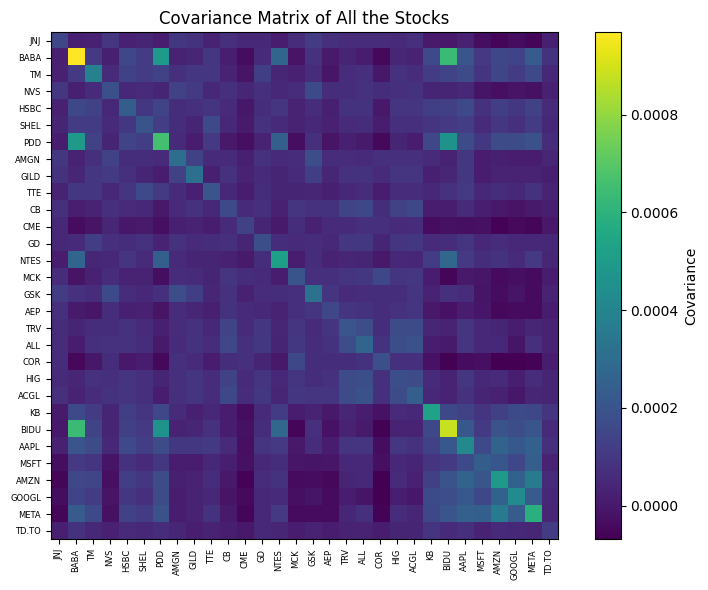

In [13]:
# If you're interested in seeing how the covariance matrix works or looks, here's a heatmap
# The darker the square, the less the two stocks move together
# Essentially the darker, the more the stocks balance each other's movements out

plt.figure(figsize=(8,6))
plt.imshow(cov_matrix, cmap="viridis")
plt.colorbar(label="Covariance")
plt.title("Covariance Matrix of All the Stocks")
plt.xticks(range(num_tickers), tickers, rotation=90, fontsize=6)
plt.yticks(range(num_tickers), tickers, fontsize=6)
plt.tight_layout()
plt.show()

# Final Portfolio Construction
 
Now we convert our optimal weights into actual shares we can buy (including fractional shares).


In [14]:
# Step 0: Make adjusted weights dataframe
results['Weight'] = results['Weight'] / results['Weight'].sum()

# Step 1: Convert investment amount to USD
# This will make it easier when it comes to transaction costs and buying both canadian and american equities
#    At least that's what I thought when I first started, though it really became more of a nuisance
#        I'm still leaving it though since it works perfectly and I don't wanna mess anything up again ;-;
investment_cad = 1_000_000
usd_cad_ticker = yf.Ticker("CADUSD=X")
cad_to_usd = usd_cad_ticker.info.get('regularMarketPrice')  # Current exchange rate
investment_usd = investment_cad * cad_to_usd

print(f"Total Budget: ${investment_cad:,.2f} CAD = ${investment_usd:,.2f} USD")
print(f"Exchange Rate: 1 USD = {1/cad_to_usd:.4f} CAD")

# Step 2: Get current prices for each stock
current_prices = {}

for ticker in results['Ticker']:
    stock = yf.Ticker(ticker)
    price = stock.info.get('regularMarketPrice')
    current_prices[ticker] = price

# Step 3: Calculate allocation, shares, and fees
portfolio_data = []
total_fees_usd = 0

# First, calculate total fees
for ticker in results['Ticker']:
    weight = results[results['Ticker'] == ticker]['Weight'].values[0]
    price = current_prices[ticker]

    # Check if this is a Canadian stock
    is_canadian = ticker.endswith('.TO')

    # Amount allocated to this stock (in USD)
    allocated_usd = investment_usd * weight
    
    if is_canadian:
        # Convert allocated USD to CAD for Canadian stocks
        allocated_cad = allocated_usd / cad_to_usd
        shares_before_fee = allocated_cad / price

        # Calculate transaction fee (either $2.15 or $0.001 per share) in USD
        fee_cad = min(2.15, 0.001 * shares_before_fee)
        fee_usd = fee_cad * cad_to_usd
    else:
        # Is US equity

        # Calculate transaction fee (either $2.15 or $0.001 per share) in USD
        shares_before_fee = allocated_usd / price
        fee_usd = min(2.15, 0.001 * shares_before_fee)
    
    total_fees_usd += fee_usd

# Investable amount after fees
investable_usd = investment_usd - total_fees_usd

# Now allocate using the investable amount
for ticker in results['Ticker']:
    weight = results[results['Ticker'] == ticker]['Weight'].values[0]
    price = current_prices[ticker]

    # Check if this is a Canadian stock
    is_canadian = ticker.endswith('.TO')

    # Amount allocated to this stock (in USD)
    allocated_usd = investable_usd * weight
    
    if is_canadian:
        # Convert allocated USD to CAD for Canadian stocks
        allocated_cad = allocated_usd / cad_to_usd

        # Determine final amount of shares per stock
        shares_final = allocated_cad / price

        # How much it's worth in CAD
        value_cad = shares_final * price
        
        portfolio_data.append({
            'Ticker': ticker,
            'Price': price,
            'Currency': 'CAD',
            'Shares': shares_final,
            'Value (CAD)': value_cad,
            'Weight': weight  
        })
    else:
        # USA USA USA
        # Determine final amount of shares per stock
        shares_final = allocated_usd / price

        # How much it's worth in USD
        value_usd = shares_final * price

        # How much it's worth in CAD
        value_cad = value_usd / cad_to_usd  
        
        portfolio_data.append({
            'Ticker': ticker,
            'Price': price,
            'Currency': 'USD',
            'Shares': shares_final,
            'Value (CAD)': value_cad,  
            'Weight': weight  
        })

# Step 4: Create final DataFrame
Portfolio_Final = pd.DataFrame(portfolio_data)
Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

# Now all values are in CAD, so just sum them and stuff
total_invested_cad = Portfolio_Final['Value (CAD)'].sum()
total_fees_cad = total_fees_usd / cad_to_usd

# Display results
print(f"\nTotal Fees:        ${total_fees_cad:,.2f} CAD (${total_fees_usd:,.2f} USD)")
print(f"Total Invested:    ${total_invested_cad:,.2f} CAD")
print(f"Cash Remaining:    ${investment_cad - total_fees_cad - total_invested_cad:,.2f} CAD")
print(f"Weight Sum:        {Portfolio_Final['Weight'].sum():.6f}")
print(f"\n{Portfolio_Final.to_string()}\n")

# Step 5: Export CSV file
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']].copy()

group_number = "1259"  
Stocks_Final.to_csv(f"Stocks_Group_{group_number}.csv", index=False)

print(f"Saved Stocks_Group_{group_number}.csv")
print(f"\n{Stocks_Final.to_string(index=False)}")

Total Budget: $1,000,000.00 CAD = $715,103.03 USD
Exchange Rate: 1 USD = 1.3984 CAD

Total Fees:        $6.29 CAD ($4.49 USD)
Total Invested:    $999,993.71 CAD
Cash Remaining:    $0.00 CAD
Weight Sum:        1.000000

   Ticker   Price Currency       Shares    Value (CAD)    Weight
1     CME  279.28      USD   384.076793  149999.318035  0.150000
2   TD.TO  114.93      CAD  1136.993476  130674.660240  0.130675
3     AEP  123.51      USD   690.020709  119177.872469  0.119179
4     JNJ  200.04      USD   362.265316  101338.619526  0.101339
5    MSFT  493.79      USD   132.943151   91799.357551  0.091800
6     COR  361.69      USD   170.005297   85986.513079  0.085987
7     TTE   64.94      USD   598.314843   54334.220753  0.054335
8    NTES  139.19      USD   171.279156   33338.336907  0.033339
9    BIDU  117.14      USD   203.517453   33337.901598  0.033338
10   AMZN  222.55      USD   107.115237   33335.750303  0.033336
11  GOOGL  284.28      USD    83.854271   33335.185317  0.033335
1